# introduction
- problem statement : classifying the type of food in an image using a convolutional neural network

For this project I will be using the Food-101 dataset (kaggle link: https://www.kaggle.com/datasets/kmader/food41 ) to build and train a convolutional neural network that recognises different types of food when given an image as input.  For the purposes of making the notebook relatively efficient to run on most hardware, I scaled the dataset down to only include pictures of chicken wings or ice cream, giving me a total of 2000 images.  However instead of building the model like a binary classifier, I used categorical crossentropy loss functions and softmax activations on the output layers.  This means that I could theoretically use the same model structures in this notebook to train on the entire dataset if I adjust the number of units in the output layer appropriately. 

I chose this dataset because of how balanced and well organized it was, with plenty of examples from all classes.  Although I picked this dataset mainly for usability, one example of a real world use case for using deep learning to classify pictures of food is if a carlorie tracking app (ex. MyFitnessPal) wanted to add a feature where a user can take a picture of their food and the app gives an estimate of how many calories it has. 

# Preparation and preprocessing

## importing necessary packages

In [43]:
import os
import shutil
import random
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten,AveragePooling2D,LeakyReLU
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.metrics import Precision, Recall, AUC

## data splitting

Below is the code I used to pull the subset I wanted out of the full dataset and break it into train, validation and test directories using a 75-15-15 split.  Since I included the directories I made in my submission (os.path.isdir('valid') is True), the code in this cell will be ignored but I left it in to show how I prepared the data.

In [2]:
if os.path.isdir('valid') is False:

    # Paths to desired directories in full dataset
    chicken_directory = 'images/chicken_wings'
    icecream_directory='images/ice_cream'


    # creating new directories for split
    os.makedirs('train/chicken')
    os.makedirs('test/chicken')
    os.makedirs('valid/chicken')

    os.makedirs('train/icecream')
    os.makedirs('test/icecream')
    os.makedirs('valid/icecream')


    # listing image files, shuffling
    chicken_files = os.listdir(chicken_directory)
    icecream_files = os.listdir(icecream_directory)
    random.shuffle(chicken_files)
    random.shuffle(icecream_files)


    # creating 75-15-15 split
    train_chic = chicken_files[:700]
    test_chic = chicken_files[700:850]
    valid_chic = chicken_files[850:]

    train_ice = icecream_files[:700]
    test_ice = icecream_files[700:850]
    valid_ice = icecream_files[850:]


    # Copy images to desired directories
    for image in train_chic:
        src = os.path.join(chicken_directory, image)
        dst = os.path.join('train/chicken', image)
        shutil.copy(src, dst)

    for image in train_ice:
        src = os.path.join(icecream_directory, image)
        dst = os.path.join('train/icecream', image)
        shutil.copy(src, dst)    

    for image in test_chic:
        src = os.path.join(chicken_directory, image)
        dst = os.path.join('test/chicken', image)
        shutil.copy(src, dst)

    for image in test_ice:
        src = os.path.join(icecream_directory, image)
        dst = os.path.join('test/icecream', image)
        shutil.copy(src, dst)
        
    for image in valid_chic:
        src = os.path.join(chicken_directory, image)
        dst = os.path.join('valid/chicken', image)
        shutil.copy(src, dst)

    for image in valid_ice:
        src = os.path.join(icecream_directory, image)
        dst = os.path.join('valid/icecream', image)
        shutil.copy(src, dst)

edit the variables below to match the directory you saved the data in

In [3]:
#saving directories
train_path=r'C:\Users\broba\deep_learning\food_image_classification\train'
valid_path=r'C:\Users\broba\deep_learning\food_image_classification\valid'
test_path=r'C:\Users\broba\deep_learning\food_image_classification\test'

# Building initial model

## processing data for model.fit() function

For my models, I will be using Keras sequential model functionality.  This means that for the model.fit() function to work it needs to take the input data through a Keras generator.  Using ImageDataGenerator().flow_from_directory() will make batches of data from the specified location on disc that can be used to train and evaluate the models.

In [23]:
data_generator = ImageDataGenerator(rescale=1/255.) 

train = data_generator.flow_from_directory(
    directory=train_path, 
    target_size=(224,224),
    classes=['chicken', 'icecream'], 
    batch_size=10
)


valid = data_generator.flow_from_directory(
    directory=valid_path, 
    target_size=(224,224),
    classes=['chicken', 'icecream'], 
    batch_size=10
)


test = data_generator.flow_from_directory(
    directory=test_path, 
    target_size=(224,224),
    classes=['chicken', 'icecream'], 
    batch_size=10,
    shuffle=False
)

Found 1400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


This output shows that the train, validation and test sets have the expected size and number of classes.  Below I use a function from the keras documentation to provide a visual for the data being fed into the model.

In [5]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [6]:
imgs, labels = next(train)

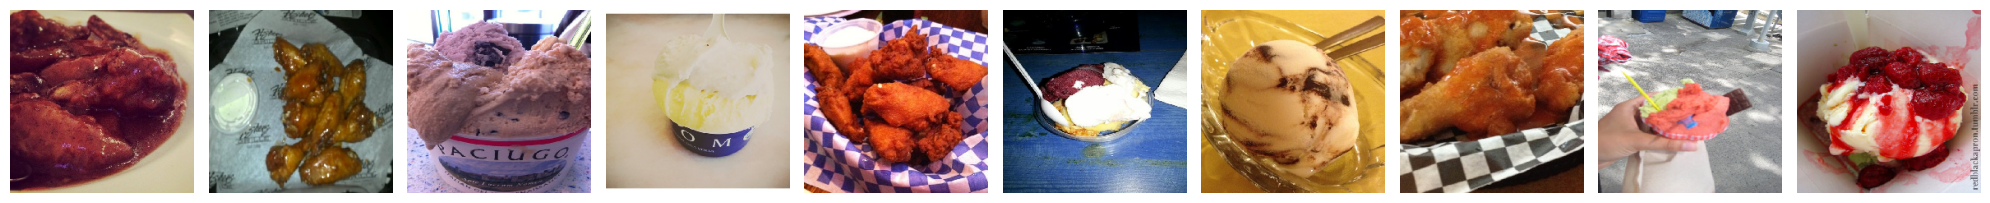

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]]


In [7]:
plotImages(imgs)
print(labels)

Here are some examples of the images as the model will see them along with their one-hot encoded label vectors.  A \[1.0.\] represents chicken wings and a \[0.1.\] label represents ice cream.

## building basic convolutional model

Now that the data is in the right format to be used as input for a keras sequential model, I can build and train a simple convolutional model to use as a baseline for performance.  For this I used just 2 convolutional layers with fairly standard options for the hyperparameters.  For this model to run, the input shape should match the target size specfied in flow_from_directory(), (224,224,3) in this case, with the 3 representing the 3 color chanels for RGB.

In [10]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 200704)            0         
                                                                 
 dense (Dense)               (None, 2)                 4

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

The cell below as well, as any other cell calling model.fit(), may take a few minutes

In [13]:
baseline1=model.fit(x=train,
    validation_data=valid,
    validation_steps=len(valid),
    epochs=10,
    verbose=2
)

Epoch 1/10
140/140 - 31s - loss: 0.4944 - accuracy: 0.7543 - val_loss: 0.3698 - val_accuracy: 0.8367 - 31s/epoch - 224ms/step
Epoch 2/10
140/140 - 32s - loss: 0.3501 - accuracy: 0.8593 - val_loss: 0.3818 - val_accuracy: 0.8233 - 32s/epoch - 227ms/step
Epoch 3/10
140/140 - 30s - loss: 0.3182 - accuracy: 0.8657 - val_loss: 0.3435 - val_accuracy: 0.8500 - 30s/epoch - 217ms/step
Epoch 4/10
140/140 - 30s - loss: 0.2550 - accuracy: 0.9086 - val_loss: 0.3462 - val_accuracy: 0.8400 - 30s/epoch - 215ms/step
Epoch 5/10
140/140 - 30s - loss: 0.1935 - accuracy: 0.9357 - val_loss: 0.3545 - val_accuracy: 0.8333 - 30s/epoch - 213ms/step
Epoch 6/10
140/140 - 29s - loss: 0.1488 - accuracy: 0.9557 - val_loss: 0.3683 - val_accuracy: 0.8167 - 29s/epoch - 209ms/step
Epoch 7/10
140/140 - 31s - loss: 0.1171 - accuracy: 0.9729 - val_loss: 0.3855 - val_accuracy: 0.8200 - 31s/epoch - 220ms/step
Epoch 8/10
140/140 - 33s - loss: 0.0873 - accuracy: 0.9807 - val_loss: 0.3923 - val_accuracy: 0.8167 - 33s/epoch - 237

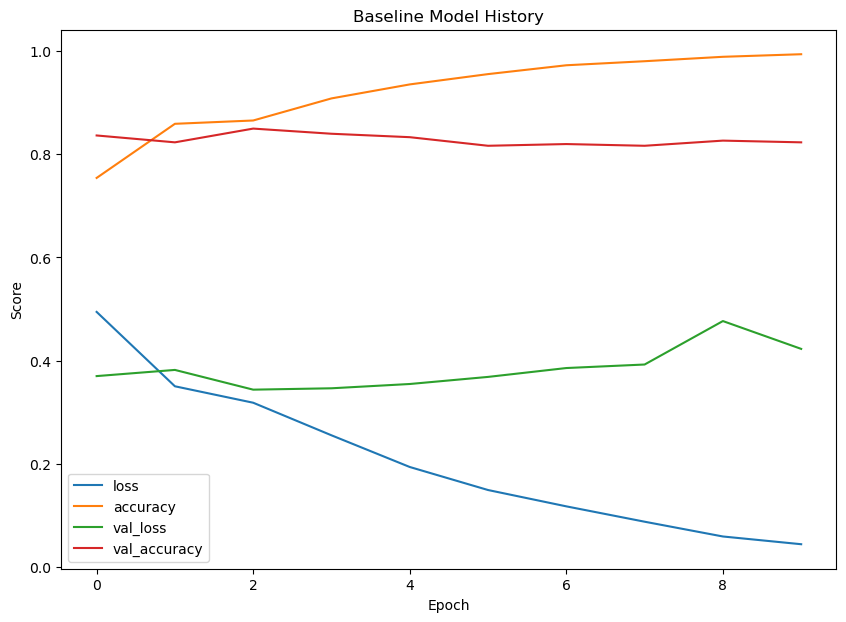

In [55]:
ax=pd.DataFrame(baseline1.history).plot(figsize=(10,7))

ax.set_title("Baseline Model History")  
ax.set_xlabel("Epoch")  
ax.set_ylabel("Score")  

plt.show()

When plotting the history of this model, it shows that it is clearly being overfit.  This is evidenced by the training accuracy getting close to 100% as the epochs progress while the validation accuracy stays in the low 80s.

## using image augmentation to mitegate overfitting

The overfitting problem seen above can be treated by using a preprocecing step called image augmentation.  To do this, I recreate the generators to perform a number of transformations on the images in the data batches.  Effectively, applying different transformations to the data in every epoch of training gives the effect of training the model on a more diverse dataset.  This can make the model generalize better and prevent overfitting.  Validation and test data are being processed the same as before

In [57]:
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(
    rescale=1./255
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [16]:
train_batches = datagen.flow_from_directory(
    directory=train_path, 
    target_size=(224,224),
    classes=['chicken', 'icecream'], 
    batch_size=10
)

Found 1400 images belonging to 2 classes.


In [58]:
valid_batches = valid_datagen.flow_from_directory(
    directory=valid_path, 
    target_size=(224,224),
    classes=['chicken', 'icecream'], 
    batch_size=10
)

Found 300 images belonging to 2 classes.


In [59]:
test_batches = test_datagen.flow_from_directory(
    directory=test_path, 
    target_size=(224,224),
    classes=['chicken', 'icecream'], 
    batch_size=10,
    shuffle=False
)

Found 300 images belonging to 2 classes.


For a better idea of what is actually happening to the images to give the effect of more diverse data, the code below displays a random image from the original training set as well as its transformed state after augmentation.

In [61]:
#creating unshuffled batches to get the same random image from both
train_unshuffled = data_generator.flow_from_directory(
    directory=train_path, 
    target_size=(224,224),
    classes=['chicken', 'icecream'], 
    batch_size=10,
    shuffle=False
)

train_aug_unshuffled= datagen.flow_from_directory(
    directory=train_path, 
    target_size=(224,224),
    classes=['chicken', 'icecream'], 
    batch_size=10,
    shuffle=False
)

Found 1400 images belonging to 2 classes.
Found 1400 images belonging to 2 classes.


In [62]:
#unaugmented example
images, labels = train_unshuffled.next()
#augmented example
augmented_images, augmented_labels = train_aug_unshuffled.next()

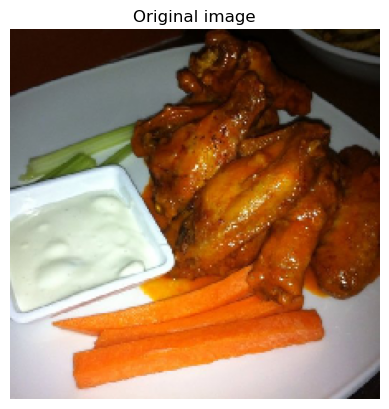

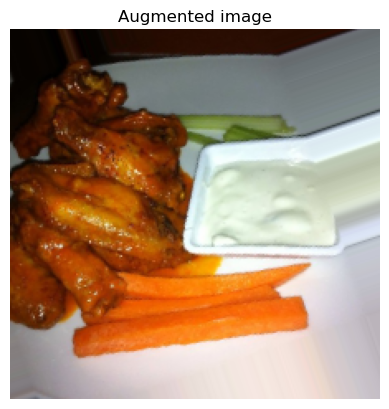

In [63]:
#showing random augmented vs unaugmented images
random_number = random.randint(0, 9)
plt.imshow(images[random_number])
plt.title(f"Original image")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented image")
plt.axis(False);

Next I re-trained the model on using augmentation and compare the results to the original

In [64]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [65]:
baseline2=model.fit(x=train_batches,
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
140/140 - 45s - loss: 0.5290 - accuracy: 0.7300 - val_loss: 0.3703 - val_accuracy: 0.8500 - 45s/epoch - 323ms/step
Epoch 2/10
140/140 - 41s - loss: 0.4418 - accuracy: 0.7986 - val_loss: 0.3536 - val_accuracy: 0.8433 - 41s/epoch - 296ms/step
Epoch 3/10
140/140 - 41s - loss: 0.4117 - accuracy: 0.8293 - val_loss: 0.3435 - val_accuracy: 0.8500 - 41s/epoch - 296ms/step
Epoch 4/10
140/140 - 42s - loss: 0.4005 - accuracy: 0.8343 - val_loss: 0.3338 - val_accuracy: 0.8667 - 42s/epoch - 300ms/step
Epoch 5/10
140/140 - 41s - loss: 0.4049 - accuracy: 0.8343 - val_loss: 0.3280 - val_accuracy: 0.8667 - 41s/epoch - 292ms/step
Epoch 6/10
140/140 - 41s - loss: 0.3971 - accuracy: 0.8429 - val_loss: 0.3507 - val_accuracy: 0.8600 - 41s/epoch - 291ms/step
Epoch 7/10
140/140 - 41s - loss: 0.3813 - accuracy: 0.8379 - val_loss: 0.3456 - val_accuracy: 0.8633 - 41s/epoch - 295ms/step
Epoch 8/10
140/140 - 42s - loss: 0.3870 - accuracy: 0.8443 - val_loss: 0.3239 - val_accuracy: 0.8500 - 42s/epoch - 300

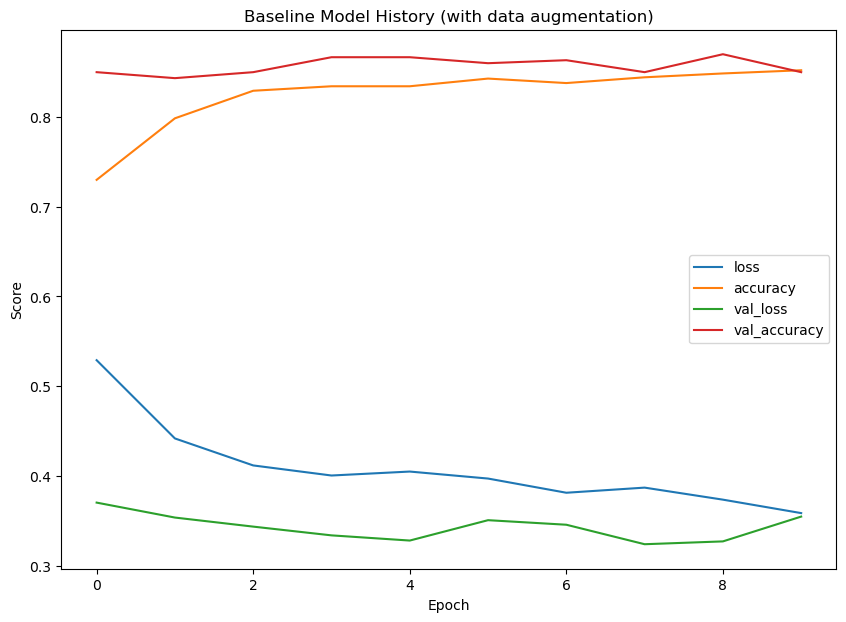

In [68]:
ax=pd.DataFrame(baseline2.history).plot(figsize=(10,7))

ax.set_title("Baseline Model History (with data augmentation)")  
ax.set_xlabel("Epoch")  
ax.set_ylabel("Score")  

plt.show()

This model does not show the signs of overfitting that the previous one had and it performs better on the validation set.  It also appears to converge fairly early on.

# tuning hyperparameters

Fine tuning a network is can be fairly complicated since it would take too much time to simply run a grid search like I would with a simpler model like a decision tree.  I approached fine tuning my model by maually training neural networks with slightly different hyperparameters than the baseline (only 5 epochs for the sake of time) in order to observe the effects of the different hyperparameters on performance.  I cut the majority of the altnate models from the final notebook so it will run in a reasonable amount of time. Below is a list of the hyperparameters I tried tweaking:
- number of layers (convolutional layers as well as adding hidden layers)
- number of filters 
- kernel size 
- pooling size
- average pooling vs max pooling
- different activation functions
- different learning rate optimizers

Out of all these, increasing the number of filters was the only thing that seemed to cause a non-negligable boost in performance.  The changes listed below seemed to cause some increase in performance but not enough to be sure it wasn't random
- adding 1 dense layer with selu activation
- using rmsprop as an optimizor instead of adam
- setting pool size to 3,3 instead of 2,2

## comparing 2 other potential models

Below are 2 alternate models I build with different hyperparameters to compare with the baseline model.  In the first model, I decided to only make the one change that caused seemed to cause a significant performance boost. The only difference between this and the baseline is increasing the number of filters on both convolutional layers.  For the second model, I made all the changes that seemed to boost performance at all, even if the performance increase was small enough to possibly be random.  This includes increasing the number of filters in addition to adding 1 dense layer with selu activation, using RMSprop instead of adam and increasing the pool size.

first tuned model - just increasing number of filters

In [67]:
model_tuned1 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

model_tuned1.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


tuned1_history=model_tuned1.fit(x=train_batches,
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
140/140 - 76s - loss: 0.5316 - accuracy: 0.7471 - val_loss: 0.3720 - val_accuracy: 0.8433 - 76s/epoch - 543ms/step
Epoch 2/10
140/140 - 69s - loss: 0.4362 - accuracy: 0.8164 - val_loss: 0.3423 - val_accuracy: 0.8533 - 69s/epoch - 496ms/step
Epoch 3/10
140/140 - 71s - loss: 0.4107 - accuracy: 0.8329 - val_loss: 0.3485 - val_accuracy: 0.8367 - 71s/epoch - 504ms/step
Epoch 4/10
140/140 - 70s - loss: 0.4221 - accuracy: 0.8271 - val_loss: 0.3740 - val_accuracy: 0.8600 - 70s/epoch - 497ms/step
Epoch 5/10
140/140 - 71s - loss: 0.3961 - accuracy: 0.8329 - val_loss: 0.3406 - val_accuracy: 0.8533 - 71s/epoch - 508ms/step
Epoch 6/10
140/140 - 72s - loss: 0.4016 - accuracy: 0.8286 - val_loss: 0.3271 - val_accuracy: 0.8767 - 72s/epoch - 512ms/step
Epoch 7/10
140/140 - 71s - loss: 0.3797 - accuracy: 0.8471 - val_loss: 0.3073 - val_accuracy: 0.8800 - 71s/epoch - 504ms/step
Epoch 8/10
140/140 - 69s - loss: 0.3618 - accuracy: 0.8493 - val_loss: 0.3300 - val_accuracy: 0.8767 - 69s/epoch - 494

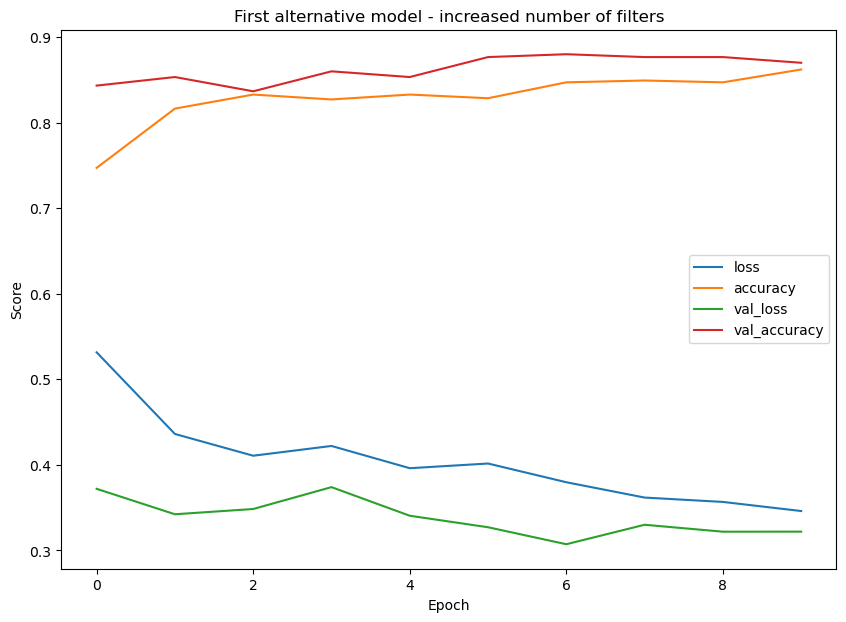

In [69]:
ax=pd.DataFrame(tuned1_history.history).plot(figsize=(10,7))

ax.set_title("First alternative model - increased number of filters")  
ax.set_xlabel("Epoch")  
ax.set_ylabel("Score")  

plt.show()

second tuned model - making every change that seemed to cause any kind of performance boost

In [70]:
model_tuned2 = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(3, 3), strides=2),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(3, 3), strides=2),
    Flatten(),
    Dense(128,activation='selu'),
    Dense(units=2, activation='softmax')
])


model_tuned2.compile(
    optimizer=RMSprop(learning_rate=0.0001), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

tuned2_history=model_tuned2.fit(x=train_batches,
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose=2
)

Epoch 1/10
140/140 - 126s - loss: 0.8825 - accuracy: 0.7364 - val_loss: 0.3796 - val_accuracy: 0.8233 - 126s/epoch - 898ms/step
Epoch 2/10
140/140 - 122s - loss: 0.4503 - accuracy: 0.8029 - val_loss: 0.3388 - val_accuracy: 0.8700 - 122s/epoch - 868ms/step
Epoch 3/10
140/140 - 130s - loss: 0.4084 - accuracy: 0.8236 - val_loss: 0.3713 - val_accuracy: 0.8233 - 130s/epoch - 930ms/step
Epoch 4/10
140/140 - 122s - loss: 0.3938 - accuracy: 0.8243 - val_loss: 0.3394 - val_accuracy: 0.8633 - 122s/epoch - 870ms/step
Epoch 5/10
140/140 - 124s - loss: 0.3867 - accuracy: 0.8293 - val_loss: 0.3563 - val_accuracy: 0.8433 - 124s/epoch - 885ms/step
Epoch 6/10
140/140 - 124s - loss: 0.3811 - accuracy: 0.8364 - val_loss: 0.3143 - val_accuracy: 0.8700 - 124s/epoch - 883ms/step
Epoch 7/10
140/140 - 122s - loss: 0.3798 - accuracy: 0.8400 - val_loss: 0.3206 - val_accuracy: 0.8633 - 122s/epoch - 874ms/step
Epoch 8/10
140/140 - 127s - loss: 0.3648 - accuracy: 0.8464 - val_loss: 0.3301 - val_accuracy: 0.8733 - 

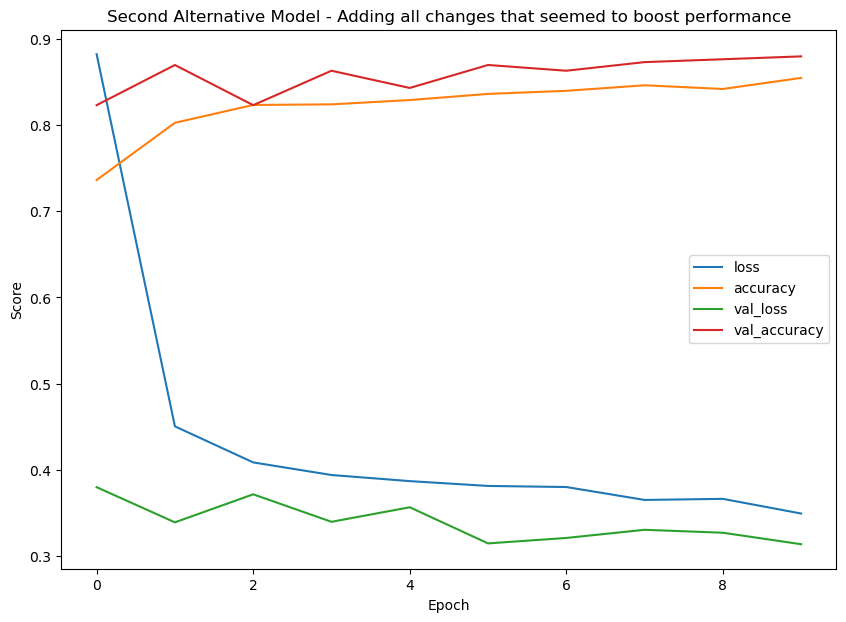

In [71]:
ax=pd.DataFrame(tuned2_history.history).plot(figsize=(10,7))

ax.set_title("Second Alternative Model - Adding all changes that seemed to boost performance")  
ax.set_xlabel("Epoch")  
ax.set_ylabel("Score")  

plt.show()

Both of these models perform almost the same, being a little bit better than the baseline while still not showing signs of overfitting.  This leads me to choose the first of the two because it is simpler and more computationally efficient.

# final testing

Here I test the final model on my test set and plot the confusion matrix and classification report.

In [72]:
predictions = model_tuned1.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [73]:
y_pred = np.argmax(predictions, axis=-1)

In [74]:
#from scikit docs
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[134  16]
 [ 39 111]]


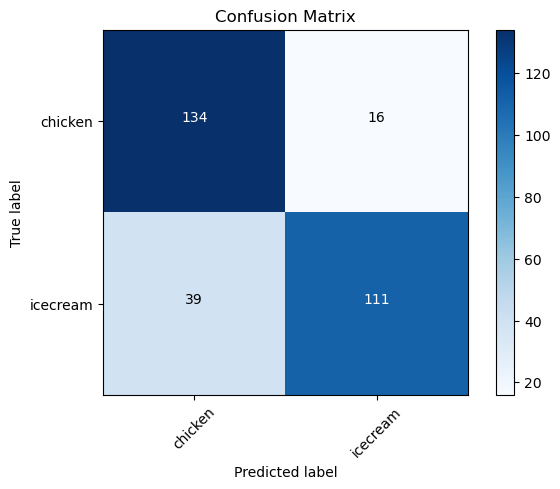

In [75]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=y_pred)
cm_plot_labels = ['chicken','icecream']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [76]:
print(classification_report(test_batches.classes, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.89      0.83       150
           1       0.87      0.74      0.80       150

    accuracy                           0.82       300
   macro avg       0.82      0.82      0.82       300
weighted avg       0.82      0.82      0.82       300



# conclusions and next steps

An accuracy of 0.82 is somewhat dissapointing compared to the performance on the validation set.  This could possibly be a result of me accidentally tuning the model to overfit the validation data.  Looking at the confusion matrix, this seems to classify ice cream as chicken disproportionaltely.  If I were to try again to make this model better I might add different labels within the icecream category for different flavors to prevent the model from getting confused by the colors and classifying chocolate icecream as chicken.